In [17]:
%reset -f

# Build your own Gaussian process (GP lab part 3)

**Machine Learning, University of Zaragoza, Ruben Martinez-Cantin**

This lab exercise allows you to implement your own Gaussian processes for regression. You can compare the results here with the results you got from the exercise with GPy.

# How to submit the results

Make a copy of this file in your Drive. Then you can use textboxes to write directly your report. Download as .ipynb and submit that file in Moodle.

In [18]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25, 10)
plt.rcParams["font.size"] = 16

# Function for plotting/shading.
def GaussPDFscaled(y, m, s):
  return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)

In [19]:
# Optimization function. Used for the hyperparameter tuning/learning
from scipy.optimize import dual_annealing

# Cholesky decomposition functions
from scipy.linalg import cho_solve, cho_factor

We are going to use the [same data](https://drive.google.com/file/d/1wGlqnkXU-Fv6Tu8k0x3a5BR6CieLm_06/view?usp=sharing) used in the regression examples from the course slides. Of course, you can, and you should, try with a different dataset, like the [weight dataset](https://drive.google.com/file/d/1YYyQG-xuS1OV5Ww1ytZLzhe3YdvE_NKG/view?usp=sharing) from [Philipp Hennig](https://uni-tuebingen.de/en/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/methoden-des-maschinellen-lernens/personen/philipp-hennig/)

Note: if you use your own data set, use only one data dimension. GPs are able to perform multidimensional regression, but the code is slightly longer and more complicated. Also, the implementation that we are using is not robust to outliers.

In [ ]:
# !wget https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/data_gp.npz
# !wget https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/weightdata_clean.mat

In [20]:
def load_data(use_data_gp = True):

  # Load the data from the file
  if use_data_gp:
    data = np.load('data_gp.npz')
    dataX = data['X']
    dataY = data['Y']
  
  else:
    # You can also use the weight dataset.
    # Note that for the weight dataset we select a random subset of just 100 points
    # to avoid large computation times.
    data=scipy.io.loadmat('weightdata_clean.mat')

    # random selection of 100 points
    id = np.array(range(len(data['dat'])))
    np.random.shuffle(id)
    id = id[:1000]

    dataX = np.atleast_2d(data['dat'][id,0]).T
    dataY = np.atleast_2d(data['dat'][id,1]).T

  # We normalize the data.
  # This is better to adjust the lengthscale and also for plotting
  dataX -= dataX.min()
  dataX /= dataX.max() - dataX.min()

  return dataX, dataY

# GP implementation
This is the code to implement a GP class. There are already implemented several methods for initialization, plotting, tunning the hyperarameters, etc.

You also have already implemented the Square Exponential kernel
$$
k(x_1,x_2) = \sigma_s^2 \cdot \exp{\left(\frac{|x_1-x_2|^2}{2l^2}\right)}
$$

## Prediction
Your job is to compute the prediciton function to return both the predicted mean $\widehat{f_*}$ and variance $\sigma^2_{f_*}$ for a query point $\bf x_*$.

Remember that:
$$
\begin{align}
\widehat{f_*} &= k(x_*,X) (k(X,X) + \sigma^2_nI)^{-1} \mathbf{y}\\
\sigma^2_{f_*} &= k(x_*,x_*) - k(x_*,X) (k(X,X) + \sigma^2_nI)^{-1} k(X, x_*)\\
\end{align}
$$
where the kernel matrix is:
$$
k(X,X) = \left(\begin{array}{ccc}
k(x_1,x_1) & \ldots & k(x_1,x_n) \\
k(x_2,x_1) & \ldots & k(x_2,x_n) \\
\vdots & \ddots & \vdots\\
k(x_n,x_1) & \ldots & k(x_n,x_n)\\
\end{array}\right)
$$
and the correlation vector is:
$$
k(x_*,X) = k(X,x_*)^T = \left(\begin{array}{c}
k(x_1,x_*)\\
k(x_2,x_*)\\
\vdots\\
k(x_n,x_*)\\
\end{array}\right)
$$

For the prediction, remember than in numpy, the matrix multiplication is `A @ B`, the transpose `A.T` and the inverse is `numpy.linalg.inv(A)`.

If you want to try the more efficient method from the slides, you can use the Cholesky decomposition with `L = cho_factor(K)` and the solve command, with is represented in the slides as $L \backslash y$ can be computed `cho_solve(L,y)`. Both functions are loaded from `scipy.linalg`.

## Log-likelihood
If you want to learn the hyperparameters, you also need to implement the log-likelihood method. Again, you can use the straightforward method and implement this equation:

$$
\log p(y|X,\theta) = -\frac{1}{2}\mathbf{y}^T (k(X,X) + \sigma^2_nI)^{-1} \mathbf{y} -\frac{1}{2}\log|k(X,X) + \sigma^2_nI| -  \frac{n}{2}\log 2\pi
$$

where $|k(X,X)|$ is the determinant of the covariance matrix. Or you can implement the version from the slides using the Cholesky decomposition.

Notes:
- The method requires the **negative** log-likelihood because the algorithm that we use for optimization finds the minimum, instead of the maximum.
- You need to recompute the whole covariance matrix every time you compute the log-likelihood because the kernel hyperarameters have changed.
- Usually, it is better to use a gradient based optimization for maximum likelihood, but we use a gradient-free version so you don't need to implement it. :-)



In [21]:
class GP:
  def __init__(self, X, Y, kernel_type='squared_exponential'):
    # Store the dataset
    self.X = X
    self.Y = Y

    # Kernel hyperparameters (default values)
    self.ell = 1.0
    self.sigma_s = 1.0

    # Observation noise / likelihood (also hyperparameter)
    self.sigma_n = 1.0

    # Kernel type
    self.kernel_type = kernel_type

  def set_kernel_type(self, kernel_type):
    self.kernel_type = kernel_type
    
    # Reset kernel hyperparameters (default values)
    self.ell = 1.0
    self.sigma_s = 1.0

    # Reset observation noise / likelihood (also hyperparameter)
    self.sigma_n = 1.0


  def kernel(self, x1, x2, kernel_type='squared_exponential'):
    ell = self.ell
    sigma = self.sigma_s
    
    if kernel_type == 'squared_exponential':
        return sigma * np.exp(-0.5 * (x1 - x2)**2 / ell)
    elif kernel_type == 'matern32':
        sqrt3 = np.sqrt(3)
        d = np.abs(x1 - x2)
        return sigma * (1 + sqrt3 * d / ell) * np.exp(-sqrt3 * d / ell)
    else:
        raise ValueError(f"Unknown kernel type: {kernel_type}")

  def compute_kernel_matrix(self):
    # Computes the kernel matrix for the dataset points
    X = self.X
    return self.kernel(X, X.T)

  def compute_cross_correlation(self, x):
    # Computes the correlation between the dataset points and a new point x
    X = self.X
    return self.kernel(x, X.T)

  def predict(self, x):

    ###################################################################
    # YOUR CODE HERE.
    # COMPUTE THE VALUES OF MEAN f* AND COV sigma2_f* EVALUATED AT x
    ###################################################################

    X = self.X
    y = self.Y
    k_xStar_X = self.compute_cross_correlation(x)
    K = self.compute_kernel_matrix() + self.sigma_n**2 * np.eye(len(X))
    Kinv = np.linalg.inv(K)
    k_xStar_xStar = self.kernel(x, x)

    mean = k_xStar_X @ Kinv @ y
    cov = k_xStar_xStar - k_xStar_X @ Kinv @ k_xStar_X.T

    return mean, cov
  
  def predict_with_cho(self, x):

      X = self.X
      y = self.Y
      k_xStar_X = self.compute_cross_correlation(x)
      K = self.compute_kernel_matrix() + (self.sigma_n ** 2) * np.eye(len(X))
      
      #Kinv with cholesky
      L = cho_factor(K)
      alpha = cho_solve(L, y)

      k_xStar_xStar = self.kernel(x, x)

      mean = k_xStar_X @ alpha
      v = cho_solve(L, k_xStar_X.T)
      cov = k_xStar_xStar - (k_xStar_X @ v)

      return mean, cov

  def neg_log_likelihood(self, hyperparams):
    # Computes the negative log-likelihood for hyperarameter tuning

    # We assign the hyperparameters that we are evaluating as the GP
    # hyperparameters. If we call the kernel now, it will be with the new
    # hyperparameters.
    self.ell = np.exp(hyperparams[0])
    self.sigma_s = np.exp(hyperparams[1])
    self.sigma_n = np.exp(hyperparams[2])

    ###################################################################
    # YOUR CODE HERE.
    # COMPUTE THE VALUE OF THE NEGATIVE LOG-LIKELIHOOD.
    # Note that the new leghtscale and sigma are already asigned.
    ###################################################################

    X = self.X
    y = self.Y
    K = self.compute_kernel_matrix() + (self.sigma_n ** 2) * np.eye(len(self.X))
    Kinv = np.linalg.inv(K)

    #	The first term measures how well the predictions match the true values.
	  #	The second term penalizes models with too much uncertainty.
	  #	The third term is just a constant adjustment for the data size  n.(Source: ChatGPT)
    first_term = 0.5 * y.T @ Kinv @ y
    second_term = 0.5 * np.log(np.linalg.det(K))
    third_term = 0.5 * len(X) * np.log(2 * np.pi)

    negative_log_likelihood = first_term + second_term + third_term


    return negative_log_likelihood
  
  def neg_log_likelihood_with_cho(self, hyperparams):
    # Computes the negative log-likelihood for hyperarameter tuning

    # We assign the hyperparameters that we are evaluating as the GP
    # hyperparameters. If we call the kernel now, it will be with the new
    # hyperparameters.
    self.ell = np.exp(hyperparams[0])
    self.sigma_s = np.exp(hyperparams[1])
    self.sigma_n = np.exp(hyperparams[2])

    X = self.X
    y = self.Y
    K = self.compute_kernel_matrix() + (self.sigma_n ** 2) * np.eye(len(X))

    # Kinv with cholesky
    L = cho_factor(K)
    alpha = cho_solve(L,y)

    first_term = 0.5 * y.T @ alpha
    second_term = np.sum(np.log(np.diag(L[0])))
    third_term = 0.5 * len(X) * np.log(2 * np.pi)

    negative_log_likelihood = first_term + second_term + third_term

    return negative_log_likelihood

  def tune_hyperparameters(self):
    # Method to optimize the hyperparameters. It will call neg_log_likelihood
    # with several versions of the hyperparameters and return the values with the
    # minimum neg_log_likelihood, that is, the maximum log_likelihood.

    # Trivia: the hyperparameters can be very large or very small.
    # It is very tricky to do so searching uniformly. Instead, we optimize the
    # log(hyperparameter). Intuitively, we are optimizing the order of magnitude.
    # This way, we have more resolution with smaller values, which is what we want.
    bounds = [(-6, 6), (-6, 6), (-6, 6) ]
    ret = dual_annealing(self.neg_log_likelihood_with_cho, bounds)
    if ret.success:
      print("Updating hyperparameters. New values: ", np.exp(ret.x))
      self.ell = np.exp(ret.x[0])
      self.sigma_s = np.exp(ret.x[1])
      self.sigma_n = np.exp(ret.x[2])
    
    return ret.success, ret.fun, np.exp(ret.x)


  def plotGP(self):
    # Plotting function. We just take a grid of 100 points in the whole interval
    # and we compute the predicion at those points.
    fig, ax = plt.subplots(1,1)
    xin = np.linspace(-0.2,1.2,100)
    output = [self.predict_with_cho(x) for x in xin]
    mx, stdp = [np.array([mean for mean, cov in output]).flatten(),
                np.array([np.sqrt(cov) for mean, cov in output]).flatten()]

    yy = np.linspace(self.Y.min()-3, self.Y.max()+3, 200).reshape([200, 1])
    shadow = GaussPDFscaled(yy, mx, stdp)
    ax.imshow(
        shadow, extent=[-0.2,1.2, self.Y.min()-3, self.Y.max()+3], aspect="auto", origin="lower", cmap="Blues", alpha=0.4
    )

    ax.plot(xin , mx, "-", color='b')
    ax.plot(xin , mx + 2 * stdp, "-", color='steelblue')
    ax.plot(xin , mx - 2 * stdp, "-", color='steelblue')
    ax.plot(self.X, self.Y, 'ko')



# GP Data

Updating hyperparameters. New values:  [3.13833066e-02 3.18602951e+01 5.93397812e-01]
Negative log-likelihood: 35.63913148893275


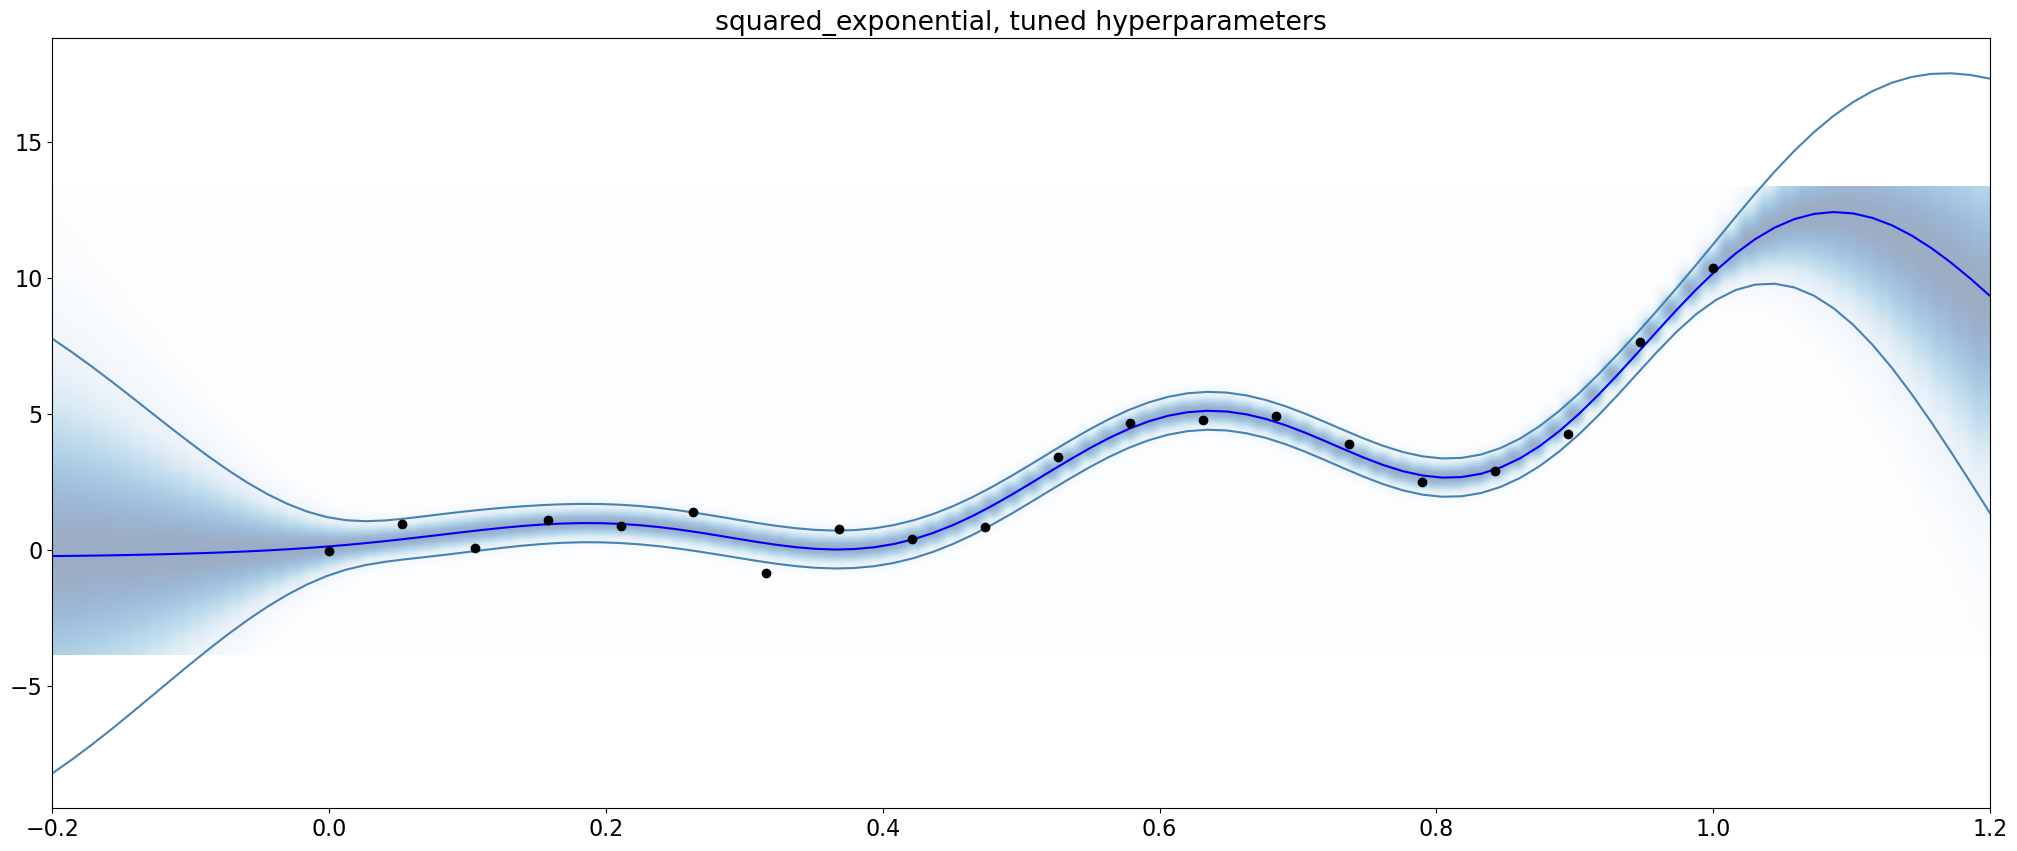

Updating hyperparameters. New values:  [3.13833387e-02 3.18603128e+01 5.93393760e-01]
Negative log-likelihood: 35.63913148856813


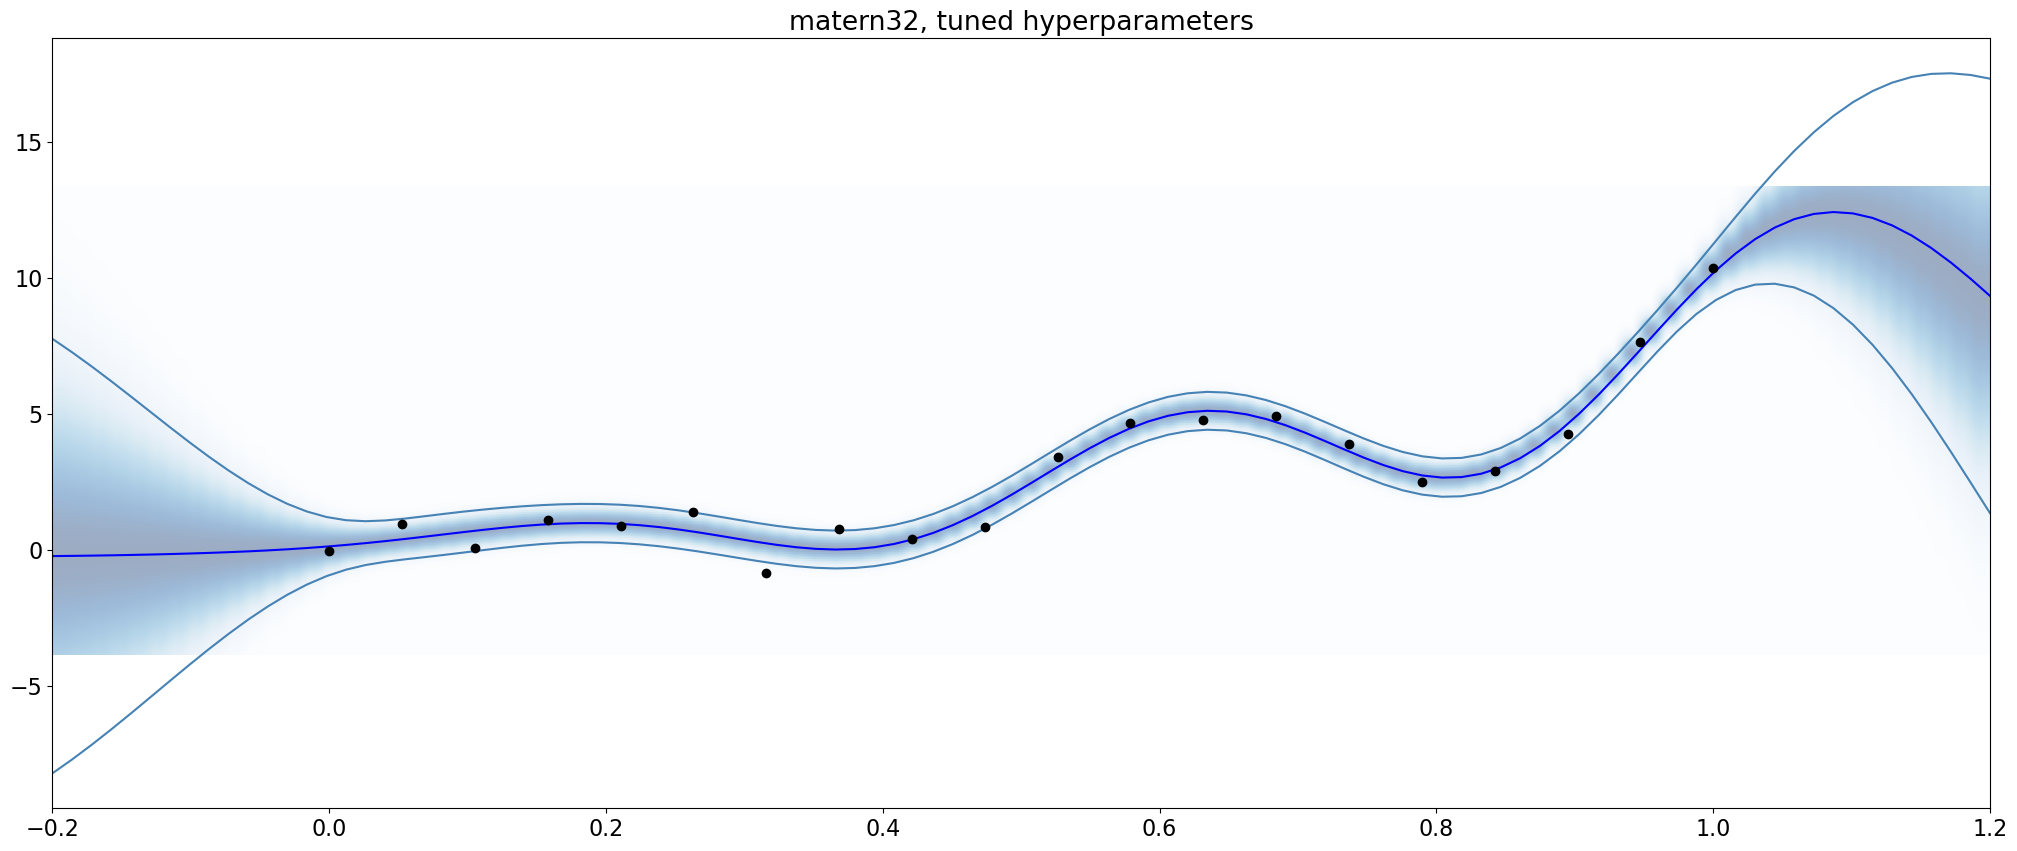

In [25]:
dataX, dataY = load_data(use_data_gp = True)

# Exponential kernel
gp = GP(dataX, dataY, kernel_type='squared_exponential')

_, neg_log_likelihood, _ = gp.tune_hyperparameters()
print(f"Negative log-likelihood: {neg_log_likelihood}")
gp.plotGP()
plt.title(f"{gp.kernel_type}, tuned hyperparameters")  
plt.show()

gp.set_kernel_type('matern32')
_, neg_log_likelihood, _  = gp.tune_hyperparameters()
print(f"Negative log-likelihood: {neg_log_likelihood}")
gp.plotGP()
plt.title(f"{gp.kernel_type}, tuned hyperparameters")
plt.show()


# Weight data + Cross-Validation + Test

## Cross-validate func (With help of ChatGPT)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def cross_validate(kernel_type, dataX, dataY, n_splits=5):
    mse_scores = []
    neg_log_likelihoods = []
    rets = []
    
    for _ in range(n_splits):
        # Split the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(dataX, dataY, test_size=0.2, random_state=None)
        
        # Initialize and train the GP model
        gp = GP(X_train, y_train, kernel_type=kernel_type)
        _, neg_log_likelihood, ret = gp.tune_hyperparameters()
        y_pred, _ = gp.predict_with_cho(X_val)
        
        # Calculate MSE
        mse = mean_squared_error(y_val, y_pred)
        
        # Store the results
        mse_scores.append(mse)
        neg_log_likelihoods.append(neg_log_likelihood)
        rets.append(ret)
    
    return np.mean(mse_scores), np.std(mse_scores), np.mean(neg_log_likelihoods), np.std(neg_log_likelihoods), np.mean(rets, axis=0)

Updating hyperparameters. New values:  [3.50282553e-03 9.53416767e+00 7.02930229e-01]
Updating hyperparameters. New values:  [3.17137322e-03 9.34632983e+00 6.84123176e-01]
Updating hyperparameters. New values:  [3.63314685e-03 9.41185622e+00 6.73829871e-01]
Updating hyperparameters. New values:  [3.92662632e-03 1.02612631e+01 7.13701391e-01]
Updating hyperparameters. New values:  [3.80686625e-03 9.58528622e+00 6.98924671e-01]
Squared Exponential Kernel - MSE: 0.5341310526027715 +/- 0.07665758903578243, NLL: 621.1288616549962 +/- 10.080577222045205
Updating hyperparameters. New values:  [3.08045253e-03 9.44538090e+00 6.72056292e-01]
Updating hyperparameters. New values:  [3.66396248e-03 9.64776128e+00 7.02520364e-01]
Updating hyperparameters. New values:  [2.98149751e-03 9.20605338e+00 7.03540800e-01]
Updating hyperparameters. New values:  [3.98902940e-03 9.79165163e+00 7.14766150e-01]
Updating hyperparameters. New values:  [3.22004702e-03 9.61193266e+00 6.88373815e-01]
Matern32 Kernel 

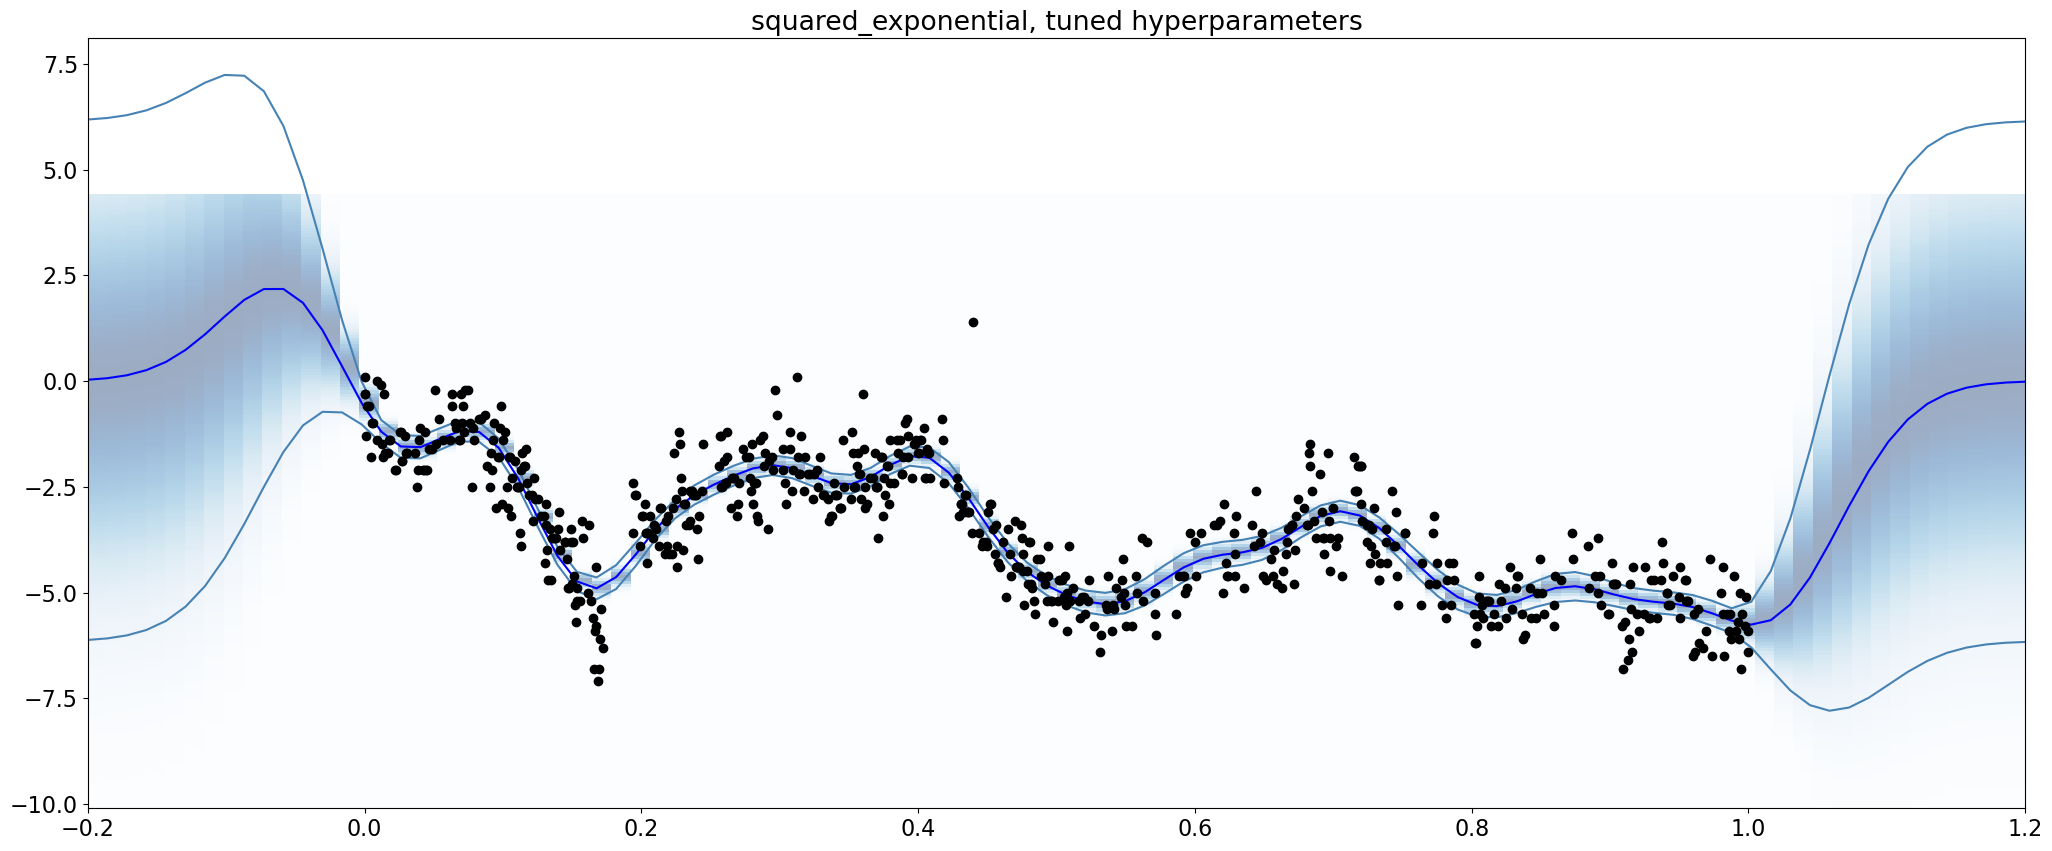

Test MSE: 0.4382344760251744, Test NLL: 770.263277340975
Updating hyperparameters. New values:  [3.30405249e-03 9.46083899e+00 6.97373116e-01]


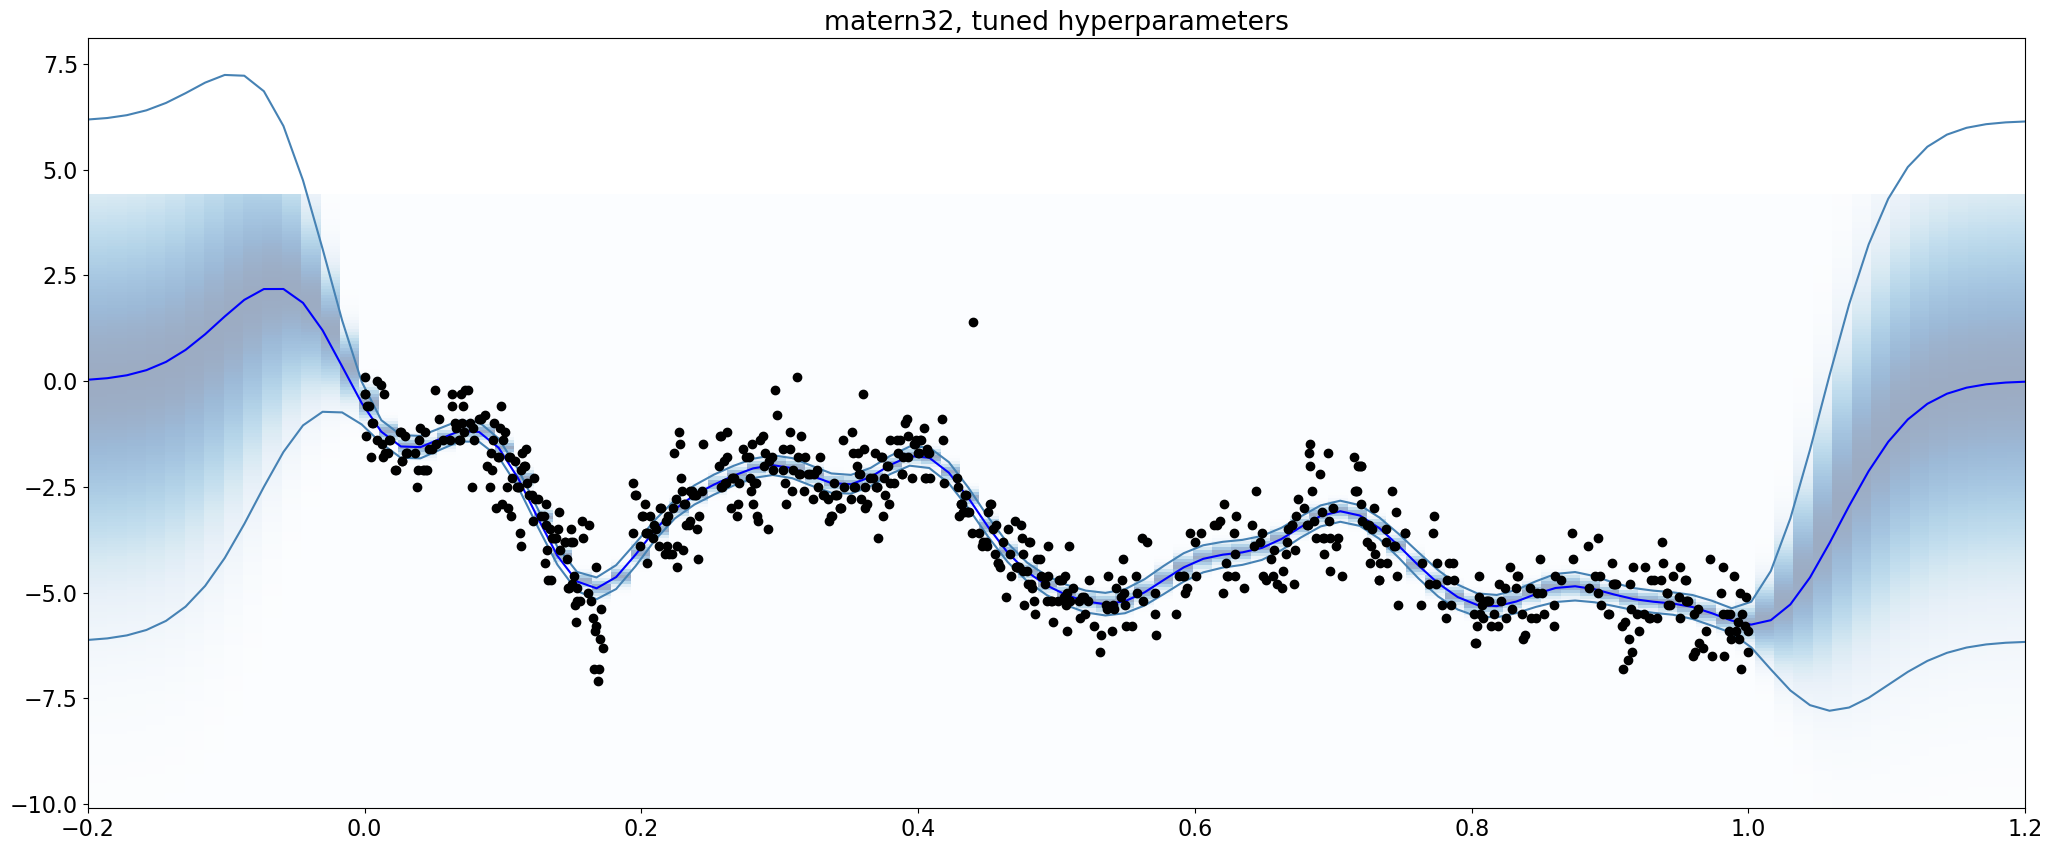

Test MSE: 0.43823453830483095, Test NLL: 770.263277344687


In [29]:

dataX, dataY = load_data(use_data_gp=False)

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)

mse_mean_se, mse_std_se, nll_mean_se, nll_std_se, ret_mean_se = cross_validate('squared_exponential', X_train, y_train)
print(f"Squared Exponential Kernel - MSE: {mse_mean_se} +/- {mse_std_se}, NLL: {nll_mean_se} +/- {nll_std_se}")

mse_mean_m32, mse_std_m32, nll_mean_m32, nll_std_m32, ret_mean_m32 = cross_validate('matern32', X_train, y_train)
print(f"Matern32 Kernel - MSE: {mse_mean_m32} +/- {mse_std_m32}, NLL: {nll_mean_m32} +/- {nll_std_m32}")

# Plot results for visual inspection
gp_se = GP(X_train, y_train, kernel_type='squared_exponential')
_, neg_log_likelihood, _ = gp_se.tune_hyperparameters()
gp_se.plotGP()
plt.title(f"squared_exponential, tuned hyperparameters")
plt.show()
y_test_pred, _ = gp_se.predict_with_cho(X_test)
test_mse_se = mean_squared_error(y_test, y_test_pred)
test_nll_se = neg_log_likelihood
print(f"Test MSE: {test_mse_se}, Test NLL: {test_nll_se}")

gp_m32 = GP(X_train, y_train, kernel_type='matern32')
_, neg_log_likelihood, _ = gp_m32.tune_hyperparameters()
gp_m32.plotGP()
plt.title(f"matern32, tuned hyperparameters")
plt.show()
y_test_pred, _ = gp_m32.predict_with_cho(X_test)
test_mse_m32 = mean_squared_error(y_test, y_test_pred)
test_nll_m32 = neg_log_likelihood
print(f"Test MSE: {test_mse_m32}, Test NLL: {test_nll_m32}")


# Your tasks

**Choose one between 1. and 2.** There is no extra points for implementing both versions! If you do 1, you can get as much as a 9.0 grade. If you do 2, you can get 10.0 grade.

1. Implement the prediction and log-likelihood methods using the standard equations (with the inverse).

2. (Alternative to 1 for extra points) If you implement the prediction with the Cholesky decompose using the equations / algorithms from the slides.

3. Implement a different kernel for comparison. For example: the Matern 3/2 kernel. The code for computing the covariance matrix and correlation vector assumes that the kernel can be vectorized, which can be tricky. If your kernel does not work vectoriced, replace `compute_kernel_matrix` and `compute_cross_correlation` using loops.

$$
k_{Matern32}(x_1,x_2) = \sigma_s \left(1 + \frac{\sqrt{3}|x_1-x_2|}{l}\right) \cdot \exp\left(- \frac{\sqrt{3}|x_1-x_2|}{l}\right)
$$

In this case, $|x|$ is the absolute value.